<a href="https://colab.research.google.com/github/2mur/stereo-street/blob/main/report-graphcuts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import math

from skimage import data
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize, rescale
import matplotlib.pyplot as plt

import random
import time
from tqdm.notebook import trange, tqdm
from networkx.algorithms.flow import preflow_push

#pip install --upgrade scikit-image
#pip install tqdm

a) testing data with ground truth

(96, 96, 3)


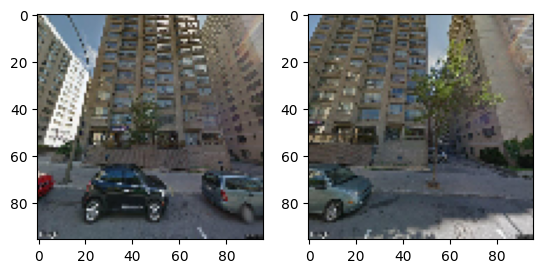

In [159]:
# load sv images
leftsv = io.imread('left_13.jpeg')
rightsv = io.imread('right_13.jpeg')
w,h,d = leftsv.shape
s = 0.15
left = rescale(leftsv, s, anti_aliasing=False, preserve_range=True, channel_axis = 2).astype('int32')
right = rescale(rightsv,s, anti_aliasing=False, preserve_range=True, channel_axis = 2).astype('int32')
print(left.shape)
fig, ax = plt.subplots(1,2)
ax[0].imshow(left, interpolation=None)
ax[1].imshow(right, interpolation=None)

original shape: (500, 741, 3) (500, 741, 3) (500, 741)
disparity range: [7.1913557052612305,59.908958435058594]
(75, 111, 3) (75, 111, 3) (75, 111)


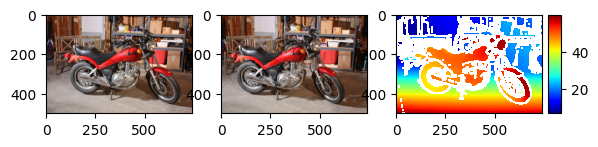

In [10]:
img_left, img_right, groundtruth_disp = data.stereo_motorcycle()
img_leftbw, img_rightbw = map(rgb2gray, (img_left, img_right))
print('original shape:',img_left.shape, img_right.shape, groundtruth_disp.shape)

woinf = groundtruth_disp.copy()
woinf[woinf == np.inf]=np.min(woinf)
print('disparity range: [{},{}]'.format(np.min(woinf),
                                        np.max(woinf)))

s = 0.15
w,h,d = img_left.shape
left = rescale(img_left, s, anti_aliasing=False, preserve_range=True, channel_axis = 2).astype('int32')
right = rescale(img_right,s, anti_aliasing=False, preserve_range=True, channel_axis = 2).astype('int32')
disp = rescale(groundtruth_disp, s, anti_aliasing=False, preserve_range=True)

print(left.shape, right.shape, disp.shape)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img_left, interpolation=None)
ax[1].imshow(img_right, interpolation=None)
im3 = ax[2].imshow(groundtruth_disp, 'jet', interpolation=None)

cax = fig.add_axes([ax[2].get_position().x1+0.01,ax[2].get_position().y0,0.02,ax[2].get_position().height])
plt.colorbar(im3, cax=cax) # Similar to fig.colorbar(im, cax = cax)

In [78]:
def D_p_graph(Gl_ney, Gr_ney, params):
    '''
    function to calculate node potential for the stereo problem
    using grid graphs to aggregate matching cost
    input
    p: (x,y) - pixel value
    d: int - disparity value
    Gl: networkx G - reference image
    Gr: networkx G  - right image to get energy computation from
    metric: str - L1 or L2
    prob: probability of printing; p,q matched_neighbors for p and q, n_matched_neighbors
    output
    C_pd: float - aggregated pixel p cost at disparity d
    '''
    metric = params['node-metric']
    k = params['k']
    n_nodes = len(Gl_ney)

    #sum match cost around neighbors of p
    if metric == 'L2':
      C_pd = 0
      for i in range(n_nodes):
        C_pd += np.sqrt(np.sum(  (Gl_ney[i] - Gr_ney[i])**2 ) )
      return np.min([k,C_pd/n_nodes])**2

    elif metric == 'L1':
      C_pd = 0
      for i in range(n_nodes):
        C_pd += np.sum( np.abs( Gl_ney[i] - Gr_ney[i] ) )
      return np.min([k,C_pd/n_nodes])**2
    else:
      print('select metric')
      return None

def V_pq_graph(npp, nq, params):
    '''
    function to calculate edge potential for the stereo problem
    linear model potential: V_pq = a*min(b, |d_p-d_q|)
    input
    fp: int - disparity value of pixel p
    fq: int - disparity value of pixel q
    a,b: float - parameters for slanted edge potential
    output
    V_pq: float - energy of edge between p and q
    '''
    a = params['a']; b = params['b']
    potential = params['edge-metric'];

    if potential == 'linear':
        _, fp = npp
        _, fq = nq
        V_pq = a*np.min([np.abs(fp-fq), b])
        return V_pq

    elif potential == 'potts':
        Ip, fp = npp
        Iq, fq = nq
        if fp == fq:
            if np.mean(np.abs(Ip-Iq)) > b:
                V_pq = a
            else:
                V_pq = 2*a
        else:
            V_pq = 0
        return V_pq

    else:
        print('available potential: linear, potts,')
        return None

def get_node_neighbor_potential(p, d, Gl, Gr):
    Gl_ney = []
    Gr_ney = []
    i,j = p
    q = i, j+d
    Gl_to_Gr_map = set([(i,j+d) for (i,j) in Gl.neighbors(p)])
    q_neighbors = set(Gr.neighbors(q))
    q_p_neighbor_matches = Gl_to_Gr_map.intersection(q_neighbors)

    Gl_ney.append(Gl.nodes[p]['rgb'])
    Gr_ney.append(Gr.nodes[q]['rgb'])
    for neyr in q_p_neighbor_matches: #should be in Gr coordinates
      ir, jr = neyr
      neyl = (ir,jr-d)
      Gl_ney.append(Gl.nodes[neyl]['rgb'])
      Gr_ney.append(Gr.nodes[neyr]['rgb'])

    return Gl_ney, Gr_ney

def img_to_graph(img, depth=None):
    '''
    generate a graph from image
    input: (w,h,d) image
    output: networkx grid graph
    '''
    # get edge potentials and store rgb values in nodes
    w,h, d = img.shape
    pixel_values = {}
    grid_graph = nx.grid_2d_graph(w,h)
    #print('grid graph shape', grid_graph.graph['shape'])
    if depth is None:
        for node in grid_graph.nodes:
            ni,nj = node
            pixel_values[node] = img[ni,nj,:]
        nx.set_node_attributes(grid_graph, pixel_values, "rgb")
        return grid_graph
    elif depth is not None:
        depth_map = {}
        for node in grid_graph.nodes:
            ni,nj = node
            pixel_values[node] = img[ni,nj,:]
            depth_map[node] = depth[ni,nj]
        nx.set_node_attributes(grid_graph, pixel_values, "rgb")
        nx.set_node_attributes(grid_graph, depth_map, "depth")
        return grid_graph
    else:
        print('depth error')
        return None
    return None

def update_graph_depth(Gl, labels, partitions, mode):
    '''
    update grid graph's depth values
    input:
    output:
    '''
    if mode == 'expansion':
        Pa,_ = partitions
        Gl = Gl.copy()
        alpha = labels
        for node in Pa:
            Gl.nodes[node]['depth'] = alpha

    elif mode == 'alpha-beta':
        Pa,Pb = partitions
        Gl = Gl.copy()
        alpha,beta = labels
        for node in Pa:
            Gl.nodes[node]['depth'] = alpha
        for node in Pb:
            Gl.nodes[node]['depth'] = beta
    else:
        print("mode = {'expansion', 'alpha-beta'}")
    return Gl

def get_partitions(Gl, pair):
    alpha,beta = pair
    a_pixels = []; b_pixels= []
    for node in Gl.nodes:
        if Gl.nodes[node]['depth'] == alpha:
            a_pixels.append(node)
        elif Gl.nodes[node]['depth'] == beta:
            b_pixels.append(node)
    return a_pixels, b_pixels

def get_depthmap(Gl, params):
    w,h,chan = params['shape']
    depthmap = np.zeros((w,h))
    for node in Gl.nodes:
        i,j = node
        depthmap[i,j] = Gl.nodes[node]['depth']
    return depthmap

def compare_local_energy(Gl, Gr, pair, Pafter, Pbefore, params, mode = 'alpha-beta'):
    alpha, beta = pair
    Pa_before, Pb_before = Pbefore
    Pab_before = Pa_before + Pb_before

    subG_bef = nx.subgraph(Gl, Pab_before)
    subG_aft = update_graph_depth(subG_bef, pair, Pafter, mode)

    Edb = 0; Esb=0
    for node in subG_bef.nodes:
        label = subG_bef.nodes[node]['depth']
        Gl_ney, Gr_ney = get_node_neighbor_potential(node, label, subG_aft, Gr)
        Edb += D_p_graph(Gl_ney, Gr_ney, params)

    for edge in subG_bef.edges:
        p,q = edge
        vp = (subG_aft.nodes[p]['rgb'], subG_aft.nodes[p]['depth'])
        vq = (subG_aft.nodes[q]['rgb'], subG_aft.nodes[q]['depth'])
        Esb += V_pq_graph(vp, vq, params)

    Eda = 0; Esa=0
    for node in subG_aft.nodes:
        label = subG_aft.nodes[node]['depth']
        Gl_ney, Gr_ney = get_node_neighbor_potential(node, label, subG_aft, Gr)
        Eda += D_p_graph(Gl_ney, Gr_ney, params)

    for edge in subG_aft.edges:
        p,q = edge
        vp = (subG_aft.nodes[p]['rgb'], subG_aft.nodes[p]['depth'])
        vq = (subG_aft.nodes[q]['rgb'], subG_aft.nodes[q]['depth'])
        Esa += V_pq_graph(vp, vq, params)

    E_bef = (Edb+Esb,Edb,Esb)
    E_aft = (Eda+Esa,Eda,Esa)
    return E_bef, E_aft

def get_energy(Gl,Gr,params):
    Ed = 0; Es = 0;
    toint = params['turn-int']
    for node in Gl.nodes:
        label = Gl.nodes[node]['depth']
        Gl_ney, Gr_ney = get_node_neighbor_potential(node, label, Gl, Gr)
        E = D_p_graph(Gl_ney, Gr_ney, params)
        if toint: E = int(E)
        Ed += E

    for edge in Gl.edges:
        p,q = edge
        vp = (Gl.nodes[p]['rgb'], Gl.nodes[p]['depth'])
        vq = (Gl.nodes[q]['rgb'], Gl.nodes[q]['depth'])
        E = V_pq_graph(vp, vq, params)
        if toint: E = int(E)
        Es += E

    return (Ed+Es, Ed, Es)

def initialize_depthmap(shape, min_disp, max_disp):
    '''
    initialize labels for disparity map
    '''
    w,h,d=shape
    depthmap = np.zeros((w,h))
    for j in range(0,h):
        labels_j = range(np.max([-j,min_disp]), np.min([h-j,max_disp+1]))
        depthmap[:,j] =  np.random.choice(labels_j, w)
    return depthmap

def get_pairs_labels(min_disp, max_disp):
    '''
    get unique label pairs for the alpha-beta swap graph cut alg.
    '''
    #print('stage: get_pairs_labels')
    labels = range(min_disp, max_disp+1)
    label_pairs = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            label_pairs.append( (labels[i], labels[j]))

    return label_pairs

## The $\alpha$-$\beta$ swap algorithm

In [90]:
def make_swap_graph(Gl, Gr, pair, params):
    '''
    A function to generate a graph with 'alpha' and 'beta' terminal nodes as
    described in [23] for the alpha-beta swap algorithm.

    input
    Gl: networkx G -  grid-graph nodes storing; {'rgb': np.arrag([r,g,b]), 'depth': d}
    Gr: networkx G -  grid-graph nodes storing; {'rgb': np.arrag([r,g,b])}
    pair: tuple of ints - (alpha, beta)
    params: dict - node/edge potential params

    output
    G_ab: networkx graph - graph with (alpha,beta) source and sink nodes.
    '''
    w,h, channels = params['shape']; toint = params['turn-int']
    alpha, beta = pair
    ab_graph = nx.Graph()
    ab_graph.add_nodes_from(['alpha', 'beta'])

    for p in Gl.nodes:
      if Gl.nodes[p]['depth'] in [alpha, beta]:
        i,j = p
        #calculate D_p(alpha)
        if j+alpha<=0 or j+alpha>(h-1): Dpa = 2147483647;
        else:
          Gl_ney_a, Gr_ney_a = get_node_neighbor_potential(p, alpha, Gl, Gr)
          Dpa = D_p_graph(Gl_ney_a, Gr_ney_a, params)
          if toint: Dpa = int(Dpa);

        if j+beta<=0 or j+beta>(h-1): Dpb = 2147483647;
        else:
          Gl_ney_b, Gr_ney_b = get_node_neighbor_potential(p, beta, Gl, Gr)
          Dpb = D_p_graph(Gl_ney_b, Gr_ney_b, params)
          if toint: Dpb = int(Dpb);

        #calculate V_pqs
        Ip = Gl.nodes[p]['rgb']
        npa = (Ip, alpha); npb = (Ip, beta)
        Va = 0; Vb = 0
        for q in Gl.neighbors(p):
          fq = Gl.nodes[q]['depth']
          Iq = Gl.nodes[q]['rgb']
          nq = (Iq, fq)
          if fq not in [alpha, beta]:
            Va += V_pq_graph(npa, nq, params)
            Vb += V_pq_graph(npb, nq, params)
          elif fq in [alpha, beta]:
            nqb = (Iq, beta)
            e_pq = V_pq_graph(npa,nqb, params)
            if toint: e_pq = int(e_pq)
            ab_graph.add_edge(p, q, capacity=e_pq)
          else:
            print('p,q are not in P_ab')
        if toint:
          Va = int(Va); Vb=int(Vb)
        ab_graph.add_edge('alpha', p, capacity = Dpa + Va)
        ab_graph.add_edge(p,'beta', capacity = Dpb + Vb)
    return ab_graph

def alpha_beta_swap(image_left, image_right, params):
    '''
    input
      image_left: numpy array, dim = (w,h,c)
      image_right: numpy array, dim = (w,h,c)
      labels: list of int, eg. range(-30,30)
    output:
      Gl: networkx graph
    '''
    min_disp = params['min_disp']; max_disp = params['max_disp']
    endcycle = params['endcycle']; exp = params['exp']

    times = {'initialize_depthmap':0, 'img_to_graph': 0, 'get_energy': 0,
             'get_partitions':0,'make_swap_graph':0,'minimum_cut':0,
             'compare_energy':0}

    #generate pairs of labels
    label_pairs = get_pairs_labels(min_disp, max_disp)

    # generate initial partitions of labelings
    # initial labels are generated such that for pixel (i,j),  d in {-j, h-j }
    tde1 = time.time()
    depthmap = initialize_depthmap(image_left.shape, min_disp, max_disp)
    tde2 = time.time(); times['initialize_depthmap'] = tde2 - tde1

    #generate grid graphs
    tg1 = time.time();
    Gl = img_to_graph(image_left, depth=depthmap)
    Gr = img_to_graph(image_right)
    tg2 = time.time(); times['img_to_graph'] = tg2 - tg1

    ten1 = time.time();
    E,Ed,Es = get_energy(Gl,Gr,params)
    ten2 = time.time(); times['get_energy'] = ten2 - ten1

    Etime = []
    Etime.append([E,Ed,Es])
    #alpha-beta swap cycles
    run = 1
    cycle = 0;
    iters_list = []; iters=0
    tsg = []; tc = []; tp = []; tcen=[]
    while run == 1:
        cycle+=1
        print('cycle:', cycle)
        #run each cycle, if no improvement is done, terminate.
        run = 0
        random.shuffle(label_pairs)
        for i in trange(len(label_pairs)):
            # *************** iterations *******************************************
            pair = label_pairs[i]
            alpha, beta = pair

            # initial partitions
            tp1 = time.time();
            Pbefore = get_partitions(Gl, pair)
            tp2 = time.time(); tp.append(tp2 - tp1)

            # graph construction
            ta = time.time()
            Gab = make_swap_graph(Gl, Gr, pair, params)
            tb = time.time(); tsg.append(tb - ta)

            # mincut
            tc1 = time.time();
            cut_value, Pafter = nx.minimum_cut(Gab, 'alpha','beta')
            tc2 = time.time(); tc.append(tc2 - tc1)

            # perform the swap
            Pb = Pafter[0].intersection(set(Gl.nodes))
            Pa = Pafter[1].intersection(set(Gl.nodes))
            Pafter = (Pa,Pb)

            # get energy from before and after
            tcen1 = time.time();
            bef, aft = compare_local_energy(Gl, Gr, pair, Pafter, Pbefore, params)
            E_bef, Ed_bef, Es_bef = bef
            E_aft, Ed_aft, Es_aft = aft
            tcen2 = time.time(); tcen.append(tcen2 - tcen1)
            #E_bef, _, _ = get_energy(Gl,Gr,params)
            #Gl_aft = update_graph_depth(Gl, pair, Pafter, mode='alpha-beta')
            #E_aft, Ed_aft, Es_aft = get_energy(Gl_aft,Gr,params)

            #if at any point in the cycle, the energy is lowered, keep label swap
            if E_aft < E_bef:
                run = 1
                E -= np.abs(E_bef-E_aft); Ed-= np.abs(Ed_bef-Ed_aft); Es-= np.abs(Es_bef-Es_aft)
                Etime.append([E, Ed, Es])
                Gl_aft = update_graph_depth(Gl, pair, Pafter, mode='alpha-beta')
                Gl = Gl_aft
                iters+=1
            # *************** iterations *******************************************

        # *************** cycles *******************************************
        # save image after each cycle
        iters_list.append(iters)
        fig, ax = plt.subplots()
        depthmap = get_depthmap(Gl, params)
        pos1 = ax.imshow(depthmap, 'jet', interpolation=None)
        cax1 = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(pos1, cax=cax1)
        plt.savefig(f'{exp}-cycle-{cycle}.png', dpi=100)
        plt.close()

        if cycle == endcycle:
            tsg = np.mean(tsg); tp = np.mean(tp);
            tc = np.mean(tc); tcen = np.mean(tcen)
            times['minimum_cut'] = tc; times['make_swap_graph'] = tsg;
            times['get_partitions'] = tp; times['compare_energy'] = tcen
            depthmap = get_depthmap(Gl, params)
            return depthmap, Etime, iters_list, times
        # *************** cycles *******************************************

    depthmap = get_depthmap(Gl, params)
    tsg = np.mean(tsg); tp = np.mean(tp);
    tc = np.mean(tc); tcen = np.mean(tcen)
    times['minimum_cut'] = tc; times['make_swap_graph'] = tsg;
    times['get_partitions'] = tp; times['compare_energy'] = tcen;
    return depthmap, Etime, iters_list, times

In [169]:
min_disp = -30; max_disp = 30;
nmetric = 'L2'; k = 50
emetric = 'linear'; a = 50; b = 5;

params = {'shape': left.shape, 'min_disp':min_disp, 'max_disp':max_disp, 'endcycle':5,
          'a':a, 'b':b, 'edge-metric': emetric, 'node-metric': nmetric, 'k':k, 'turn-int': False}
exp = f'abswap-d{(max_disp-min_disp)}-{emetric}-a{a}-b{b}-{nmetric}-k{k}'
params['exp']=exp

st = time.time()
depthmap, Etime, iters_list, times = alpha_beta_swap(left, right, params)
et = time.time(); t = et - st

cycle: 1


  0%|          | 0/1830 [00:00<?, ?it/s]

cycle: 2


  0%|          | 0/1830 [00:00<?, ?it/s]

cycle: 3


  0%|          | 0/1830 [00:00<?, ?it/s]

cycle: 4


  0%|          | 0/1830 [00:00<?, ?it/s]

cycle: 5


  0%|          | 0/1830 [00:00<?, ?it/s]

In [170]:
'''
times = {'initialize_depthmap':0, 'img_to_graph': 0, 'get_energy': 0,
             'get_partitions':0,'make_swap_graph':0,'minimum_cut':0}
'''
times['totaltime'] = int(t)
cyclefactor = 210*5
tott=times['totaltime']
geten = int( 100*(times['get_energy'])/tott )
initd = int( 100*(times['initialize_depthmap'])/tott )
imgtg = int( 100*(times['img_to_graph'])/tott )
comenn = int( 100*(times['compare_energy']*cyclefactor)/tott )
make = int( 100*(times['make_swap_graph']*cyclefactor)/tott )
minc = int( 100*(times['minimum_cut']*cyclefactor)/tott )

print(f'execution decomposition: {tott}s')
print(f'\t initialize_depthmap {initd}%')
print(f'\t img_to_graph {imgtg}%')
print(f'\t get_energy {geten}%')
print(f'\t compare_energy {comenn}%')
print(f'\t make_swap_graph {make}%')
print(f'\t minimum_cut {minc}%')

execution decomposition: 1791s
	 initialize_depthmap 0%
	 img_to_graph 0%
	 get_energy 0%
	 compare_energy 2%
	 make_swap_graph 4%
	 minimum_cut 1%


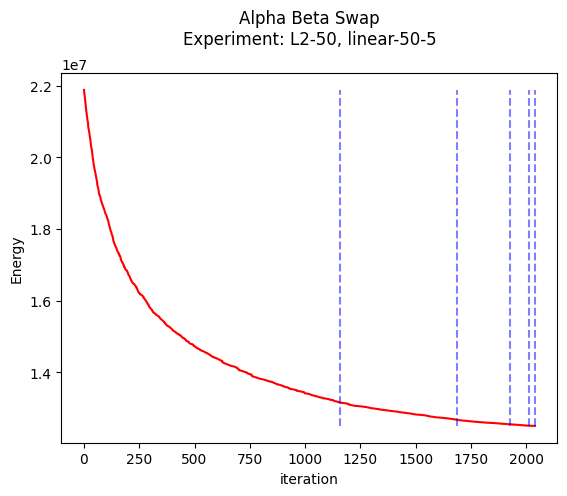

In [172]:
Etimearr = np.array(Etime)

fig, ax = plt.subplots()
pos1 = ax.imshow(depthmap, 'jet', interpolation=None)
cax1 = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(pos1, cax=cax1)
plt.savefig(f'{exp}.png',dpi=100)
plt.close()

fig, ax = plt.subplots()
ax.set_title('Total energy')
ax.plot(Etimearr[:,0], color='red')
plt.title(f'Alpha Beta Swap\nExperiment: {nmetric}-{k}, {emetric}-{a}-{b}\n')
ax.set_xlabel('iteration')
ax.vlines(x=iters_list, ymin = np.min(Etimearr[:,0]), ymax = np.max(Etimearr[:,0]),
          colors='blue',alpha =0.5, linestyles='dashed')
ax.set_ylabel('Energy')
plt.savefig(f'energy-{exp}.png',dpi=100)
